Intra session-RMS images classification.<br>
Two convolutional layers, and 2 hidden layers are used.

________________________________________________________________________________
GS parameters:

params = {'nbr_filters_hid1': [64],<br>
          'nbr_filters_hid2': [24, 32, 64, 128],<br>
          'drop_rate': list(np.linspace(0,0.5,6).astype('float32')),<br>
           'kernel_initializer':['glorot_uniform'],<br>
           'lambda_': list(np.linspace(1e-5,1e-1,5).astype('float32')) + [0]
                }


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.1

In [ ]:
!pip install git+https://github.com/autonomio/talos@1.0

In [ ]:
#define model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

import tensorflow as tf
import keras 

import matplotlib.pyplot as plt

def evaluation(prediction, gt, title=None, save=False, path=None,limit=None):
  """For a given predicted labels and ground truth, plots both of them.
  If set is large, use limit  (vector of two indeices) - boundaries to plot subset of the set. 
  f save, define also path as a folder and filename."""
  predicted_class=[]
  for sample in range(np.shape(prediction)[0]):
    predicted_class.append(np.argmax(prediction[sample,:]))
    #gt.append(np.argmax(desired_out[sample,:]))
  plt.figure(figsize=(20,10))
  if limit:
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(predicted_class[limit[0]:limit[1]])+1,color= '#FFA500',linewidths=9)# '#E2A76F'
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(gt[limit[0]:limit[1]])+1,color='#26292c',marker='*',linewidths=5)
  else:
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(predicted_class)+1,color='#355C7D',linewidths=9)
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(gt)+1,color='#FFA500',marker='*',linewidths=4)

  plt.xlabel('sample',fontsize=20)
  plt.ylabel('class',fontsize=20)
  if title:
    plt.title(title)
  #plt.legend(('predicted class','ground truth'),prop={'size': 27},loc=1)# bbox_to_anchor=(0.7,0.648))

  if save:
    plt.savefig(path)
  plt.show()


def create_CNN_Ameri_like_model(dim1,dim2,dim_labels = 9,  lambda_ = 1.675e-5, drop_rate = 0.1, nbr_hid1 = 80, nbr_hid2 = 80, kernel_initializer='glorot_uniform'):

    input_dim = (dim1,dim2,1)

    visible = Input(shape = input_dim)

    ######################################## CONVOLUTIONAL LAYERS ##########################################
    # First Block
    conv1 = Conv2D(16, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(visible)
    norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(norm1)
    pool1 = AveragePooling2D(pool_size = (2,2))(act1)

    # Second Block
    conv2 = Conv2D(32, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(norm2)
    pool2 = AveragePooling2D(pool_size = (2,2))(act2)

    ######################################## FULLY CONNECTED LAYERS #########################################

    # Fully connected layer 1
    flat = Flatten()(act2)
    hid1 = Dense(nbr_hid1, activation = 'relu', kernel_regularizer = l2(lambda_))(flat)

    # Fully connected layer 2
    drop1 = Dropout(rate = drop_rate)(hid1)
    hid2 = Dense(nbr_hid2, activation = 'relu', kernel_regularizer = l2(lambda_))(drop1)
    drop2 = Dropout(rate = drop_rate)(hid2)

    ################################################ OUTPUT ################################################

    output = Dense(dim_labels, activation = 'softmax', kernel_regularizer = l2(lambda_))(drop2)

    model = Model(inputs = visible, outputs = output)

    optim = tf.keras.optimizers.Adam()
    # Compile model 
    model.compile(optimizer = optim, 
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def CreateFit_eng_ameri(train_generator,uselesss,valid_generator,useless,params):
    
    input_dim_r = params['nmb_rows']
    input_dim_c = params['nmb_columns']
    
    #lambda_ = params['lambda_']
    drop_rate = params['drop_rate']
    nbr_hid1 = params['nbr_filters_hid1']
    nbr_hid2 = params['nbr_filters_hid2']
    kernel_initializer = params['kernel_initializer']
    
    model = create_CNN_Ameri_like_model(input_dim_r,input_dim_c,dim_labels = 9)

    # Defining the callbacks we want to use
    lrate_schedule = LearningRateScheduler(step_decay)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
    callbacks_list = [lrate_schedule,early_stopper]
    
    out = model.fit(train_generator, epochs = 50, verbose = 0, callbacks = callbacks_list, validation_data = valid_generator)

    return out, model

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
session=5
"""Fil the path in the lines 2-18  and batch size in line 20"""
df_filename=['','','']

#path to train csv file folder and file name
df_filename[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/train_200ms.csv"
#path to validation csv file folder and file name
df_filename[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/validation_200ms.csv"
#path to test csv file folder and file name
df_filename[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/test_200ms.csv"

dir_=['','','']
dir_[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Train"
dir_[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Validation"
dir_[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Test"

file_name='drive/Shared drives/Nikolina/Results/RMS images intra-session/Session'+str(session)

print(df_filename)
print(dir_)

#fill the batch size
bs=32


def step_decay(epoch):
    #We half the the learning rate each 10 epochs
    initial_l_r = 0.01
    drop = 0.5
    epochs_drop = 5
    lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))
    return lrate
    
########## LOAD THE IMAGES AND TARGETS, AND CREATE GENERATORS ##########

nmb_rows=16 #define dimensions 
nmb_columns=28 #define dimensions

#Create dataframes and datagenerators: 
#TRAIN
dft=pd.read_csv(df_filename[0])
datagen=ImageDataGenerator(rescale=1/255)#
train_generator=datagen.flow_from_dataframe(dataframe=dft,  #images folder
                                            directory= dir_[0],
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), #tuple of integers `(height, width)
                                            batch_size=bs, 
                                            color_mode="grayscale",
                                            shuffle=True)  

#VALIDATION
dfv=pd.read_csv(df_filename[1])
datagen=ImageDataGenerator(rescale=1/255)#
valid_generator=datagen.flow_from_dataframe(dataframe=dfv, 
                                            directory=dir_[1], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=True) 

#TEST
#just read with shuffle=false to make sure final plots looks like expected
dfte=pd.read_csv(df_filename[2])
datagen=ImageDataGenerator()#rescale=1/255
test_generator=datagen.flow_from_dataframe(dataframe=dfte, 
                                            directory= dir_[2], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"],
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=True)

['/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/train_200ms.csv', '/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/validation_200ms.csv', '/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/test_200ms.csv']
['/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/Train', '/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/Validation', '/content/drive/Shared drives/Nikolina/RMS data/Images/Session5/Test']
Found 308 validated image filenames.
Found 103 validated image filenames.
Found 103 validated image filenames.


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24, 32, 64, 128],
                'drop_rate': list(np.linspace(0,0.5,6).astype('float32')),#
                'kernel_initializer':['glorot_uniform'],
                'lambda_': list(np.linspace(1e-5,1e-1,5).astype('float32')) + [0] ,
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]  
                }

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs

parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = file_name,
                       x_val=valid_generator, y_val = 0)


  0%|          | 0/1 [00:00<?, ?it/s]

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


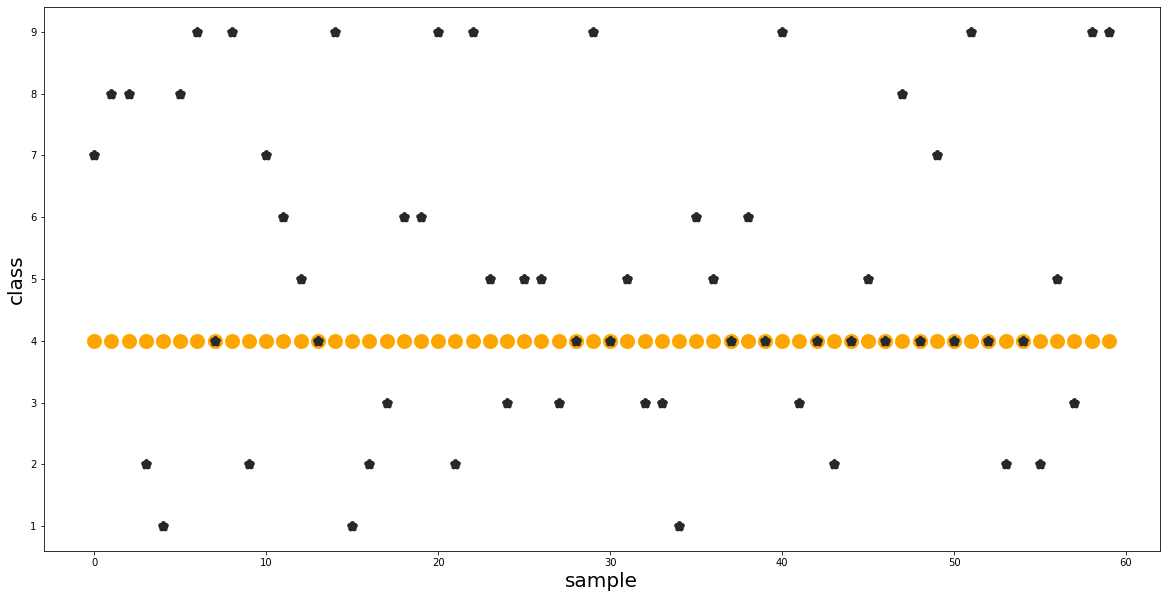


100%|██████████| 1/1 [08:47<00:00, 527.47s/it]


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24],
                'drop_rate': [0.2],#
                'kernel_initializer':['glorot_uniform'],
                'lambda_':  [1e-1] ,
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]}

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs

parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'plot',
                       x_val=valid_generator, y_val = 0)

In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24],
                'drop_rate': [0.2],#
                'kernel_initializer':['glorot_uniform'],
                'lambda_':  [1e-1] ,
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]}


import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs

for i in range (20):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN rms results/session'+str(session)+'Val',
                        x_val=valid_generator, y_val = 0)

In [ ]:
path='/content/drive/Shared drives/Nikolina/Results/RMS images - intra-session/session'+str(session)+'.csv'
results=pd.read_csv(path) 

In [ ]:
val_acc=results.val_accuracy
print(max(val_acc))
best=np.where(val_acc==max(val_acc))[0]
print(best)
print(val_acc[best])

0.19417475
[64]
64    0.194175
Name: val_accuracy, dtype: float64


In [ ]:
predictions=[]
test_acc=[]
valid_acc=[]
train_acc=[]

l=1e-1
dr=0.2
h1=64
h2=24

model = create_CNN_Ameri_like_model(nmb_rows,nmb_columns,dim_labels = 9,lambda_ = l, drop_rate = dr, nbr_hid1 = h1, nbr_hid2 = h2)
# Defining the callbacks we want to use
lrate_schedule = LearningRateScheduler(step_decay)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [lrate_schedule,early_stopper]

for i in range(20):
  print('\nTraining, iteration '+ str(i))
  h= model.fit(train_generator, epochs = 50, verbose = 0, callbacks = callbacks_list, validation_data = valid_generator)#50 epochs
  prediction = model.predict(test_generator, verbose = 0)
  test_scores = model.evaluate(test_generator, verbose = 0)
  
  print('Train accuracy:' , h.history['accuracy'][-1])
  print('Test accuracy:',test_scores[-1])
  print('Validation accuracy:',h.history['val_accuracy'][-1])

  predictions.append(prediction)

  test_acc.append(test_scores[-1])
  train_acc.append(h.history['accuracy'][-1])
  valid_acc.append(h.history['val_accuracy'][-1])

In [ ]:
print('train accuracy: '+ str(np.mean(train_acc)) + '+-' + str(np.std(train_acc)))
print('validation accuracy: '+ str(np.mean(valid_acc)) + '+-' + str(np.std(valid_acc)))
print('test accuracy: '+ str(np.mean(test_acc)) + '+-' + str(np.std(test_acc)))

train accuracy: 0.1331169+-1.4901161e-08
validation accuracy: 0.05825243+-3.7252903e-09
test accuracy: 0.087378636+-7.450581e-09


In [ ]:
out_test=list(np.where(test_generator[0][1]==1)[1])
for gen_ind in np.arange(2,len(test_generator)+1,1):
  n=(gen_ind-1)*bs
  out_test+=list(np.where(test_generator[gen_ind-1][1]==1)[1])


2
3
4
(103,)
